In [7]:
import cv2
import numpy as np
import imutils
from operator import attrgetter
import colour
from matplotlib import pyplot as plt
from skimage import exposure

ARUCO_DICT = {
"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

#Reference colors taken from Macbeth Colour Checker
#We need them for the color correction
real_colors = [
[52.0, 52.0, 52.0],
[85.0, 85.0, 85.0],
[121.0, 122.0, 122.0],
[160.0, 160.0, 160.0],
[200.0, 200.0, 200.0],
[242.0, 243.0, 243.0],
[161.0, 133.0, 8.0],
[149.0, 86.0, 187.0],
[31.0, 199.0, 231.0],
[60.0, 54.0, 175.0],
[73.0, 148.0, 70.0],
[150.0, 61.0, 56.0],
[46.0, 163.0, 224.0],
[64.0, 188.0, 157.0],
[108.0, 60.0, 94.0],
[99.0, 90.0, 193.0],
[166.0, 91.0, 80.0],
[44.0, 126.0, 214.0],
[179.0, 189.0, 103.0],
[177.0, 128.0, 133.0],
[67.0, 108.0, 87.0],
[157.0, 122.0, 98.0],
[130.0, 150.0, 194.0],
[68.0, 82.0, 115.0]
]

real_colors.reverse()

In [8]:
"""
Method to incapsulate the imshow, just for prettify the code
"""
def imshow(img, name = "img"):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

"""
This method is the preprocessing pipeline. I needed to 
change it from the classic method because the 
first implementation wasn't enough efficient on 
extracting the corners without introducing noise inside
its output.
"""
def bilateralFilteringPreprocessing(img):
    
    #Get only one channel
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Blur the image using gaussian blur
    imgBlur = cv2.GaussianBlur(gray,(7,7),2)
    
    # Smoothing without removing edges.
    gray_filtered = cv2.bilateralFilter(gray, 9, 60, 120)
  
    # Applying the canny filter
    edges_filtered = cv2.Canny(gray_filtered, 30, 50) 

    return edges_filtered

path = "C:/Users/User Pc/Desktop/Progetto OpenCV/All notebooks/aruco prototype scan.jpg"
path_sample = "C:/Users/User Pc/Desktop/Progetto OpenCV/All notebooks/prototype_aruco_v0.4.jpeg"

img = cv2.imread(path)
img_sample = cv2.imread(path_sample)



In [9]:
"""
Object that contains the parameters extracted from cv2.aruco.DetectMarkers
just for cleaner code
"""
class arucoBox():
    def __init__(self,topLeft, topRight, bottomRight, bottomLeft, idx):
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomRight = bottomRight
        self.bottomLeft = bottomLeft
        self.idx = idx

In [10]:
"""
Given an image in input, returns a list that contains
the arucoBox object identified from cv2.aruco.detectMarkers
"""
def getArucos(img):
    
    #Get the arucoDict defined earlier
    arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT["DICT_4X4_50"])
    
    #Generate the detector obj
    arucoParams = cv2.aruco.DetectorParameters_create()
   
    #Detect the different arucoBoxes inside the img
    (corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucoDict, parameters=arucoParams)
    arucos = []
    for (i,value) in zip(ids,corners):
        
        #Unpack the aruco coordinates
        (topLeft, topRight, bottomRight, bottomLeft) = value[0] 
        
        #Store them inside an array
        arucos.append(arucoBox(topLeft, topRight, bottomRight, bottomLeft,i[0]))
        
    return arucos

arucos = getArucos(img)
arucos_sample = getArucos(img_sample)

In [11]:
"""
Given a list of Arucos Markers and the image, gets 
the references using the markers with idx 1 and 2.
Also is useful to return the range of the xAxis so that
we can reuse it later to cut the chemical pads from the photo.
We also return the intervals in which the references are defined so that we can
use them later to analyze the corrected results
"""
def getReferences(arucos,img):
    #For the way the tester its structured, we need just the idx1 and 2
    aruco_1 = [aruco for aruco in arucos if aruco.idx == 1][0]
    aruco_2 = [aruco for aruco in arucos if aruco.idx == 2][0]
    
    references_coordinates = [int(aruco_2.bottomRight[1]),int(aruco_1.topLeft[1]),
                     int(aruco_2.bottomRight[0]),int(aruco_1.topLeft[0])]
    #Get the references from the image
    references = img[references_coordinates[0]:references_coordinates[1],
                     references_coordinates[2]:references_coordinates[3]]
    
    #The right and the left limit
    x_right = int(aruco_2.bottomRight[0])
    x_left  = int(aruco_1.topLeft[0])
   
    return references,references_coordinates,x_right,x_left

references, references_coordinates, x_right, x_left = getReferences(arucos,img)
references_sample, _, _, _ = getReferences(arucos_sample,img_sample)

imshow(references)
imshow(references_sample)

https://www.pyimagesearch.com/2021/02/15/automatic-color-correction-with-opencv-and-python/

https://towardsdatascience.com/histogram-matching-ee3a67b4cbc1

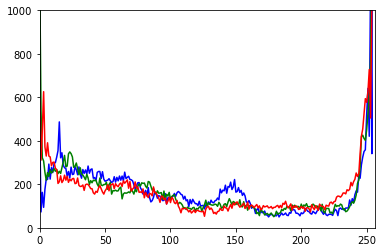

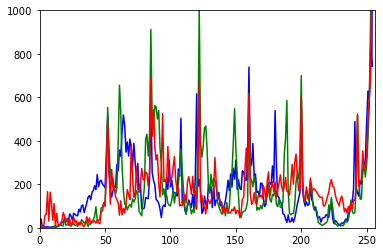

In [12]:
def plotHist(image):
    color = ('b','g','r')
    for i,col in enumerate(color):
        #List of 256 values and their quantity, so that we can write the Histogram
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
        plt.ylim([0,1000])
    plt.show()

plotHist(references)
resized = cv2.resize(references_sample, (references.shape[1],references.shape[0]), interpolation = cv2.INTER_AREA)
plotHist(resized)
#resized = cv2.resize(references, (references_sample.shape[1],references_sample.shape[0]), interpolation = cv2.INTER_AREA)


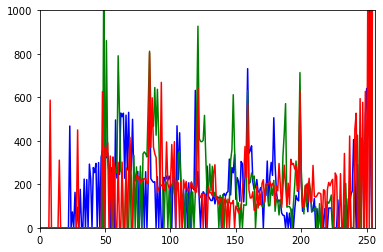

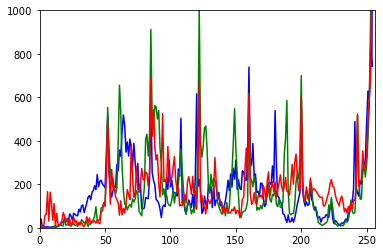

In [13]:
imageCard = exposure.match_histograms(references, resized,multichannel=True)

plotHist(imageCard)
plotHist(resized)
#imshow(imageCard)
#references = imageCard.copy()

In [14]:
imshow(cv2.hconcat([references,imageCard]))

In [15]:
"""
Method that return all the lines in the tester and also the min and max points 
from them, so that we can crop the image
"""
def getContourWithDefinedNumber(img, numberDesired):
    
  imgContour = img.copy()

  #Generate the contours using BilateralFiltering
  imgCanny = bilateralFilteringPreprocessing(img)
  
  #Store couple [[x_Start,y_Start], [X_End,y_End]] for each contour that we found
  #with the desired number of boundary points
  output = []

  #Extract all the contours from the img
  contours,hierarchy = cv2.findContours(imgCanny,cv2.RETR_LIST,
                                        cv2.CHAIN_APPROX_NONE)
  #For each contour found
  for cnt in contours:
        
    #Calculate the approximative Polygon to extract only the lines from the photo
    peri = cv2.arcLength(cnt,True)
     
    #Find the approximative Polygon based on the perimeter and the contour
    #approx is a list of points that define the polygon
    approx = cv2.approxPolyDP(cnt,0.02 * peri,True)
    
    #Number of corners of the polygon
    objCor = len(approx)
    
    #Return only the contours that have only the desired value
    if (objCor == numberDesired):
      
      #Draw the desired contour
      cv2.drawContours(imgContour,cnt,-1,(255,0,0),1)
      
      #Define the boundingRect so that, in the case of a line o a square, we have
      #The left coordinate, the width and the height
      x,y,w,h = cv2.boundingRect(approx)
      
      #Just for us to visualize the output
      cv2.rectangle(imgContour,(x,y),(x+w,y+h),(0,255,0),1)
        
      output.append(approx)
    
  #Show the output
  imshow(imgContour,str(numberDesired))

#Extract the lines from the tester using Canny Algorithm and cv2.drawContours
getContourWithDefinedNumber(img,2)

In [16]:
"""
Object that packs different methods useful for the color extraction from 
each bounding box
"""
class boxObject():
    
    """
    Init method
    """
    def __init__(self,x,y,w,h):
        self.x = x
        self.y = y
        self.h = h
        self.w = w
        self.area = w*h
    """
    Given an image and a radius(predefine at 0.3), the method return the RGB of the area defined by the radius.
    """
    def colorInside(self,img, radius = 0.1):
        
        #Extract the bounding Rect from the photo
        imageInside = img[self.y:self.y+self.h,self.x:self.x+self.w].copy()
        
        #Define the radius based on the w and h of the box
        radiusX = round(radius * self.w) 
        radiusY = round(radius * self.h)
        
        #Find the center from radiusX and radiusY
        center = imageInside[radiusX : 2*radiusX, radiusY : 2*radiusY]
        
        #Return the BGR of the area
        return [round(np.mean(center[:,:,0])),round(np.mean(center[:,:,1])),round(np.mean(center[:,:,2]))]
    
    def print(self):
        print(self.x,self.y,self.h,self.w)
        
    """
    Check if other is a duplicate of self based 
    on their distance and on the ratio
    between their areas.
    """
    def is_duplicate_of(self, other):
        x_dist = abs(self.x - other.x)
        y_dist = abs(self.y - other.y)
        area_div = self.area/other.area
        return (x_dist < 10 and 
                y_dist < 10 and 
                area_div > 0.9)

In [17]:
"""
Given an image and the number of vertex desired, returns a list
that contains the (x,y,w,h) of each elements that has pol edges
Used to extract the coordinates of each square
"""
def getPolygonCoords(img,pol = 2):
  imgContour = img.copy()
  #Preprocessing the image
  imgCanny = bilateralFilteringPreprocessing(img)
    
  #Find the contours so that we can choose the ones desired
  contours,hierarchy = cv2.findContours(imgCanny,cv2.RETR_LIST,
                                        cv2.CHAIN_APPROX_NONE)
  #Output array
  boxes = []
    
  #For each contours
  for cnt in contours:
    
    #Find the perimeter of the contour
    peri = cv2.arcLength(cnt,True)
    
    #Find the approximative Polygon based on the perimeter and the contour
    #approx is a list of points that define the polygon
    approx = cv2.approxPolyDP(cnt,0.02 * peri,True)
    
    #If has the desired number of corners
    if (len(approx) == pol):
      
      #Draw for each contour it's shape
      cv2.drawContours(imgContour,cnt,-1,(0,255,0),1)
    
      #Find the bounding rect of the approximative polygon
      x,y,w,h = cv2.boundingRect(approx)
        
      #Append it to the output array
      boxes.append(boxObject(x,y,w,h))
  
  #Just to show the different boxes extracted
  #imshow(imgContour)
  return boxes

"""
Given an image in input, returns the (min,max) of the y_coords of the lines inside the photo.
Useful to isolate the references\chemical_pads
"""
def getLinesCoords(img):
    l = getPolygonCoords(img,2)
    #Choose only the horizontal lines inside the img
    lines = [value for value in l if(value.h/value.w <0.1)]
    #Compact way to iterate,using the generators functions
    y_max = max(value.y for value in lines)
    y_min = min(value.y for value in lines)
    return y_min,y_max

"""
I want to put aruco markers instead of the line, but for now let me use this method
to return the biggest line on the tester
"""
def getCentralLine(img):
    l = getPolygonCoords(img,2)
    #Choose only the horizontal lines inside the img
    lines = [value for value in l if(value.h/value.w <0.1)]
    #We just need the biggest line on the tester
    biggest = sorted(lines, key = attrgetter("w"), reverse = True)[0]
    
    return biggest.y
    
    
    
    
#y_chemical_line,_ = getLinesCoords(img)

y_chemical_line = getCentralLine(img)
chemical_pads = img[y_chemical_line:,x_right:x_left]

#The contours extracted from the chemical pads image
getContourWithDefinedNumber(chemical_pads,4)

In [18]:
"""
Given a list of boxObjects in input, return a list without all the duplicates
"""
def removeBoxDuplicates(squares):
    set_sq = list()
    set_sq.append(squares[0])
    
    #Iterate on each different square and verify that is not a duplicate
    for i in range(1,len(squares)):
        box = squares[i]
        duplicated = False
        
        #Iterate on the set to verify the uniqueness of box
        for sq in set_sq:
            
            duplicated = duplicated or box.is_duplicate_of(sq)
            
            #if we found that box is a duplicate of something inside the array we skip it
            if duplicated:
                break;
        if not duplicated:
            set_sq.append(box)
    return set_sq

In [19]:
"""
Method that just shows the squares with their relative index
"""
def showIndexedSquares(img, set_sq):
    imgContour = img.copy()
    i = 0
    for value in set_sq:
        x = value.x
        y = value.y
        h = value.h
        w = value.w
        #Just for us to visualize the output
        cv2.rectangle(imgContour,(x,y),(x+w,y+h),(0,255,0),1)
        cv2.putText(
         imgContour, #numpy array on which text is written
         str(i), #text
         (x,y), #position at which writing has to start
         cv2.FONT_HERSHEY_SIMPLEX, #font family
         1, #font size
         (0,255,0), #font color
         3) #font stroke
        i = i+1
    imshow(imgContour)


In [20]:
"""
Given a square in input and a row y_coordinate, return True if
the square is in that row
"""
def isOnSameRow(sq1,y):
    dist = abs(sq1.y - int(y))
    return dist < 10

"""
Given a list of boxes in input, remove the boxes that aren't the boxes that we need.
We base our analysis on their area and on the (w,h) ratio.
"""
def removeStrangeBox(squares):
    mean_area = int(sum(sq.area for sq in squares)/len(squares))
    #Remove the squares that are too distant from the mean
    squares = [sq for sq in squares if sq.area/mean_area > 0.7]
    return squares

In [21]:
"""
Given a list of unordered square objects,return
the list ordered from the upper left square to the lower left one.
Is important because, for any scan we get, we need to get exaclty the squares in
the same order
"""
def orderSquares(squares):
    
    squares = sorted(squares,key = attrgetter('y'))
    #We need a dict that stores the couple{row_y_coord : [array of squares]}
    rows = dict()
    
    #Add the first element
    rows.update({str(squares[0].y):[squares[0]]})
    
    #For each squares except the first
    for sq in squares[1:]:
        
        found = False
        
        #Search if there is the row of that square
        for key in rows.keys(): 
            if isOnSameRow(sq,key):
                #Append the square to the relative row
                rows.get(key).append(sq)
                found = True
        
        #if there is not key that satisfies the constraint
        if not found:
            #Add the new row 
            rows.update({str(sq.y):[sq]})
    
    output = []
    #After creating the dict, we need to reodereach row's list and to put them 
    #in an output array
    for key in rows.keys():
        output = output + sorted(rows.get(key), key = attrgetter('x'))
    return output    

In [22]:
"""
Taken an image in input, return the coloured squares on the tester ordered from upper right 
to the lower left, so that they are aligned with the real_colors array
"""
def getOrderedSquares(img):
    
    #Get all the polygons with 4 corners
    sq_list = getPolygonCoords(img,4)
    
    #Remove the duplicates
    sq_no_duplicated = removeBoxDuplicates(sq_list)
    
    #Remove the strange boxes from the list
    sq_no_errors = removeStrangeBox(sq_no_duplicated)
    
    #Order the list so that is aligned with the reference colors list
    output = orderSquares(sq_no_errors)

    return output

showIndexedSquares(references,getOrderedSquares(references))
showIndexedSquares(chemical_pads, getOrderedSquares(chemical_pads))

set_references_sq = getOrderedSquares(references)


In [23]:
"""
given an image and a squares list, return the colors inside them
using for each square the method boxObject.colorInside
"""
def colorExtraction(squares,img):
    colors_extracted = []
    for value in squares:
        colors_extracted.append(value.colorInside(img))
    return colors_extracted

colors_extracted = colorExtraction(set_references_sq, references)

In [24]:
#Correct the colors from the first photo
cali_img = morph = img.copy()

for im in cali_img:
    im[:] = colour.colour_correction(im[:], colors_extracted, real_colors,'Finlayson 2015')

imshow(cali_img)

In [25]:
#Extract the new references from the corrected photo
references_corrected = cali_img[references_coordinates[0]:references_coordinates[1],
                                references_coordinates[2]:references_coordinates[3]]

#Get the corrected colors from the references
colors_corrected = colorExtraction(set_references_sq, references_corrected)

print("Checking the color correction accuracy")
for i in range(len(real_colors)):
        print("Color with index " + str(i))
        print("Old")
        print(colors_extracted[i])

        print("New")
        print(colors_corrected[i])
        
        print("Desired")
        print(real_colors[i])
      
        dist =  np.array(colors_corrected[i]) / np.array(real_colors[i])
        print("Accuracy(better if around 1)")
        print(dist)

        print("********")

Checking the color correction accuracy
Color with index 0
Old
[51, 52, 80]
New
[55, 55, 78]
Desired
[68.0, 82.0, 115.0]
Accuracy(better if around 1)
[ 0.80882353  0.67073171  0.67826087]
********
Color with index 1
Old
[171, 182, 235]
New
[177, 190, 234]
Desired
[130.0, 150.0, 194.0]
Accuracy(better if around 1)
[ 1.36153846  1.26666667  1.20618557]
********
Color with index 2
Old
[156, 103, 84]
New
[159, 123, 95]
Desired
[157.0, 122.0, 98.0]
Accuracy(better if around 1)
[ 1.01273885  1.00819672  0.96938776]
********
Color with index 3
Old
[17, 21, 19]
New
[31, 20, 19]
Desired
[67.0, 108.0, 87.0]
Accuracy(better if around 1)
[ 0.46268657  0.18518519  0.2183908 ]
********
Color with index 4
Old
[161, 105, 113]
New
[169, 128, 122]
Desired
[177.0, 128.0, 133.0]
Accuracy(better if around 1)
[ 0.95480226  1.          0.91729323]
********
Color with index 5
Old
[210, 171, 71]
New
[198, 187, 89]
Desired
[179.0, 189.0, 103.0]
Accuracy(better if around 1)
[ 1.10614525  0.98941799  0.86407767]
*

In [26]:
imshow(cali_img[y_chemical_line:,x_right:x_left])

From the testing, if we use a scan the contours are sharper, but the colors are brighter and this leads to a worse result in terms of color correction.
I used AdobeScan to scan the printed prototype that i have.
I want to remove the lines and substitute them with another ArUco Marker.
We need to study on how we can improve the contour detection of the chemical pads, we could add to them a darker background so that the colors are more contrastant with it, but i need to try it and also i have to change the chemical pads starting colors.

+972 584386615